
# Basic Noise Cancelling Program



In [45]:
import os
import shutil

shutil.rmtree('./tmp', ignore_errors=True)
os.makedirs('./tmp')

In [46]:
from pytube import YouTube

def download_audio_from_youtube(url, name, dest = './tmp'):
	yt = YouTube(url)
	stream = yt.streams.filter(only_audio=True).first()
	stream.download(output_path=dest, filename=name)

In [47]:
noise_video_url = 'https://www.youtube.com/watch?v=FeOrG8FrNko'
original_video_url = 'https://www.youtube.com/watch?v=FJVcGMcEw7Q'

download_audio_from_youtube(noise_video_url, "noise")
download_audio_from_youtube(original_video_url, "original")

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_audio(audio, title):
	samples = np.array(audio.get_array_of_samples())
	sample_rate = audio.frame_rate
	duration = len(samples) / sample_rate
	time = np.linspace(0., duration, len(samples))

	plt.figure(figsize=(8, 4))
	plt.plot(time, samples)
	plt.xlabel("Time [s]")
	plt.ylabel("Amplitude")
	plt.title("Audio: " + title)
	plt.show()

In [49]:
from pydub import AudioSegment

def clamp_audios(audio1, audio2):
	print('Durations before(s): ', len(audio1), len(audio2))
	shortest_duration = min(len(audio1), len(audio2))
	audio1 = audio1[:shortest_duration]
	audio2 = audio2[:shortest_duration]
	print('Durations after(s): ', len(audio1), len(audio2))
	return audio1, audio2

Durations before(s):  60372 2331423
Durations after(s):  60372 60372


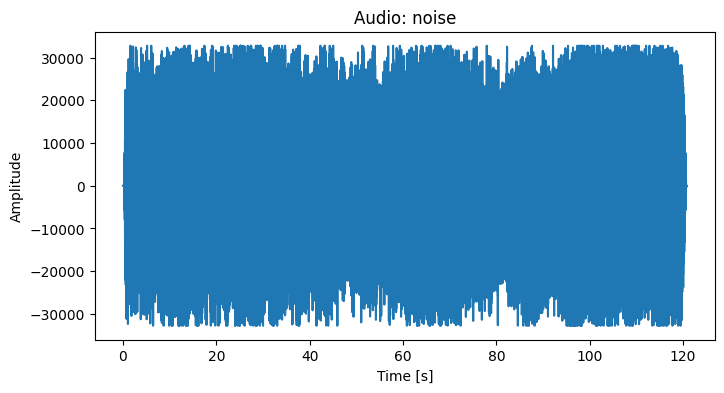

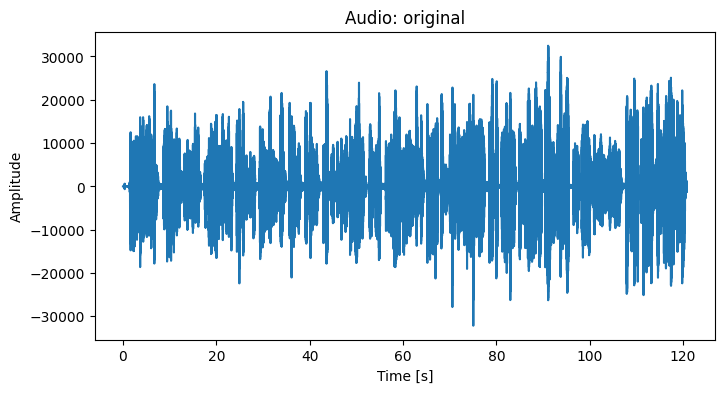

In [50]:
noise = AudioSegment.from_file('./tmp/noise')
original = AudioSegment.from_file('./tmp/original')

original.set_channels(1)
noise.set_channels(1)
noise, original = clamp_audios(noise, original)
visualize_audio(noise, 'noise')
visualize_audio(original, 'original')

In [51]:
def normalize_volume(audio1, audio2):
	print("Volumes before(dBFS): ", audio1.dBFS, audio2.dBFS)
	target_dbfs = -20
	gain1 = target_dbfs - audio1.dBFS
	gain2 = target_dbfs - audio2.dBFS
	audio1 = audio1.apply_gain(gain1)
	audio2 = audio2.apply_gain(gain2)
	print("Volumes after(dBFS): ", audio1.dBFS, audio2.dBFS)
	return audio1, audio2

Volumes before(dBFS):  -9.82339117825276 -19.88362118722665
Volumes after(dBFS):  -20.00212083742674 -19.99946987154684


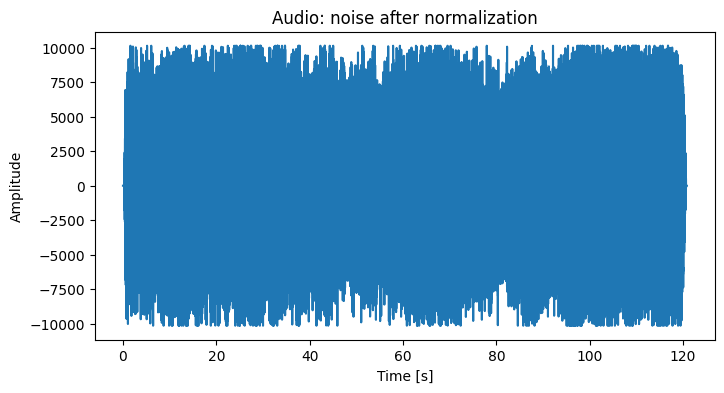

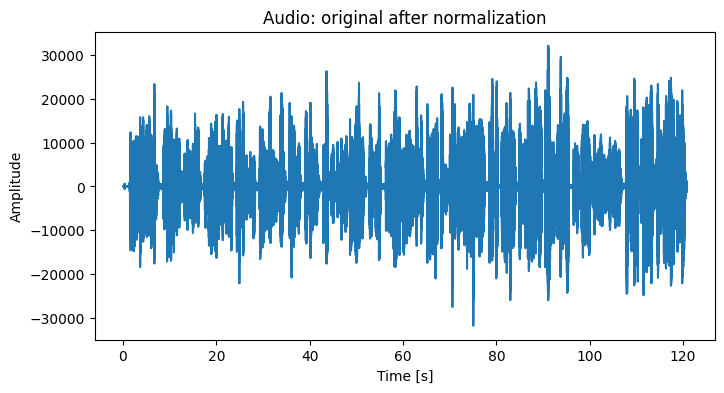

In [52]:
noise, original = normalize_volume(noise, original)
visualize_audio(noise, 'noise after normalization')
visualize_audio(original, 'original after normalization')

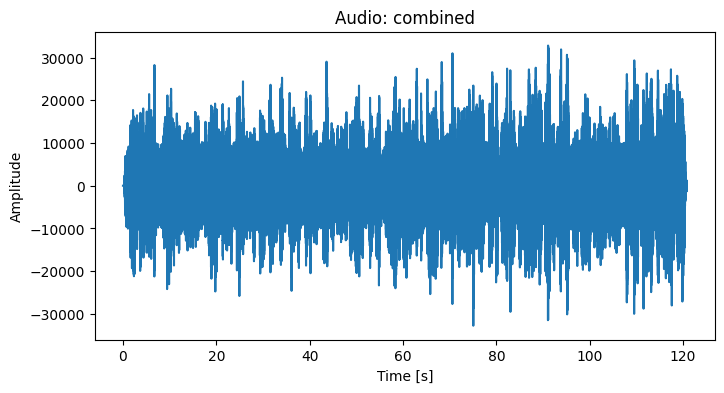

In [53]:
combined = noise.overlay(original)
combined.export('./tmp/combined.wav', format='wav')
visualize_audio(combined, 'combined')

In [54]:
import numpy as np

def pydub_to_np(audio):
    samples = np.array(audio.get_array_of_samples())
    if audio.sample_width == 2:  # 16-bit audio
        return samples.astype(np.float32) / (2**15)
    elif audio.sample_width == 4:  # 32-bit audio
        return samples.astype(np.float32) / (2**31)
    else:
        raise ValueError("Unsupported sample width")

# Function to convert numpy array back to pydub AudioSegment
def np_to_pydub(samples, frame_rate, sample_width, channels):
    if sample_width == 2:
        samples = (samples * (2**15)).astype(np.int16)
    elif sample_width == 4:
        samples = (samples * (2**31)).astype(np.int32)
    else:
        raise ValueError("Unsupported sample width")
    return AudioSegment(samples.tobytes(), frame_rate=frame_rate, sample_width=sample_width, channels=channels)

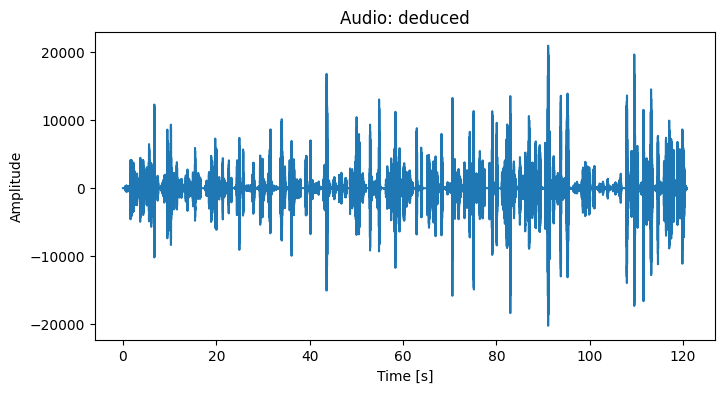

In [56]:
import noisereduce as nr

combined_np = pydup_to_np(combined)
deduced_np = nr.reduce_noise(y=combined_np, sr=combined.frame_rate)
deduced = np_to_pydub(deduced_np, combined.frame_rate, combined.sample_width, combined.channels)
deduced.set_channels(original.channels)

deduced.export('./tmp/deduced.wav', format='wav')
visualize_audio(deduced, 'deduced')

In [57]:
from sklearn.metrics import mean_squared_error

original_np = pydup_to_np(original)
deduced_np = pydup_to_np(deduced)

mse = mean_squared_error(original_np, deduced_np)
error_signal = original_np - deduced_np

def compute_snr(original, deduced):
	error_signal = original - deduced
	signal_power = np.mean(original**2)
	noise_power = np.mean(error_signal**2)
	snr = 10 * np.log10(signal_power / noise_power)
	return snr

snr = compute_snr(original_np, deduced_np)

print('Mean Squared Error: ', mse)
print('Signal to Noise Ratio: ', snr)

Mean Squared Error:  0.007216501
Signal to Noise Ratio:  1.4173033833503723


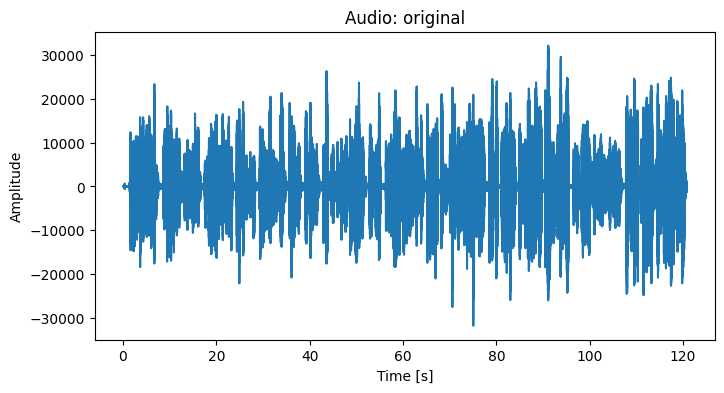

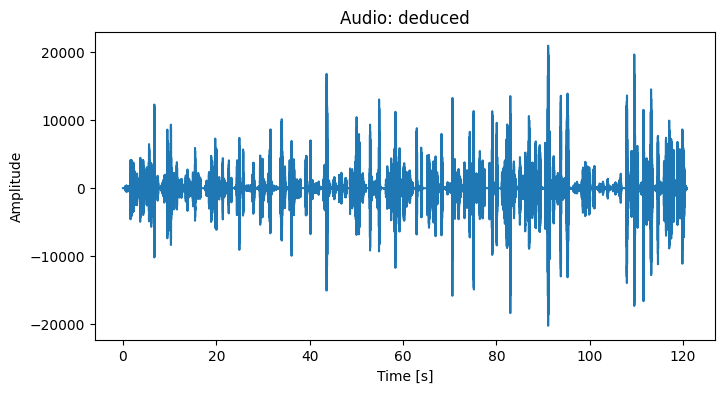

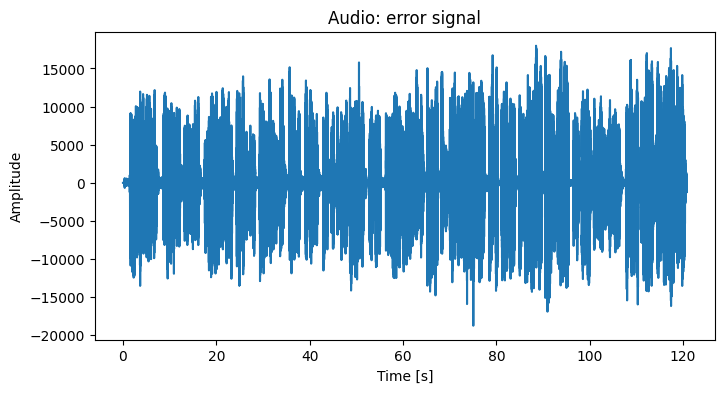

In [ ]:
visualize_audio(original, 'original')
visualize_audio(deduced, 'deduced')
visualize_audio(np_to_pydub(error_signal, combined.frame_rate), 'error signal')